In [1]:
import nltk
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
import en_core_web_lg
import gensim
import os
import emoji

nltk.download('punkt')
nltk.download('wordnet')
nlp = en_core_web_lg.load()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Pre-processing Raw Data

In [2]:
# Pre-process the data
def preprocess_data(df):
    '''
    Pre-processes the data as described above
    '''
    processed_df = df.loc[df['lang'] == "en", :].copy()
    columns_to_keep = [
        'date', 'content', 'url', 'coordinates', 'place', 'id', 'username', 
        'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
        'conversationId', 'retweetedTweet', 'quotedTweet', 'outlinks', 
        'tcooutlinks', 'media', 'mentionedUsers'
    ]
    
    processed_df = processed_df[columns_to_keep]
    processed_df.date             = pd.to_datetime(processed_df.date[:10], yearfirst=True, format="%Y-%m-%d")
    processed_df['content_clean'] = processed_df['content'].str.lower()
    processed_df['content_clean'] = processed_df['content_clean'].apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
    processed_df['content_clean'] = processed_df['content_clean'].apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))
    processed_df['content_clean'] = processed_df['content_clean'].apply(lambda x: re.sub(r'{link}', '', x))
    processed_df['content_clean'] = processed_df['content_clean'].apply(lambda x: re.sub(r"\[video\]", '', x))
    processed_df['content_clean'] = processed_df['content_clean'].apply(lambda x: re.sub(r"#\S+",'', x))
    processed_df['content_clean'] = processed_df['content_clean'].apply(lambda x: re.sub(r"@\S+",'', x))
    processed_df['content_clean'] = processed_df['content_clean'].apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', x))  
    processed_df['content_clean'] = processed_df['content_clean'].apply(lambda x: re.sub(r"[\s]{2,}",' ', x))
    processed_df['content_clean'] = processed_df['content_clean'].apply(lambda x: re.sub(r'&[a-z]+;', '', x))
    processed_df['content_clean'] = processed_df['content_clean'].apply(lambda x: re.sub(r'amp;', '', x))
    processed_df['content_clean'] = processed_df['content_clean'].apply(lambda x: re.sub(r'\(s\)', '', x))
    processed_df['content_clean'] = processed_df['content_clean'].apply(lambda x: re.sub(r'\n', ' ', x))
    processed_df['content_clean'] = processed_df['content_clean'].apply(lambda x: re.sub(r':', '', x))
    processed_df['content_clean'] = processed_df['content_clean'].apply(lambda x: re.sub(r'-', '', x))
    processed_df['content_clean'] = processed_df['content_clean'].apply(lambda x: x.strip())

    return processed_df

In [5]:
# Load Twitter data
path, dirs, files = next(os.walk("data/"))
df_list = []
  
# Pre-process
for file in files:
    if ("preprocessed_data" not in file) and ("dgmm_results" not in file):
        raw_df = pd.read_csv("data/" + file)
        clean_df = preprocess_data(raw_df)
        df_list.append(clean_df)

In [6]:
# Append all the dataframes and save to data directory
main_df = pd.concat([df for df in df_list], ignore_index=True)
main_df.to_csv('data/preprocessed_data.csv')

In [7]:
# Read in and drop those with missing data
main_df = pd.read_csv('./data/preprocessed_data.csv', index_col=0)
main_df = main_df[main_df['content_clean'].notna()]
main_df.head()

,date,content,url,coordinates,place,id,username,replyCount,retweetCount,likeCount,quoteCount,conversationId,retweetedTweet,quotedTweet,outlinks,tcooutlinks,media,mentionedUsers,content_clean
0,2021-04-30 20:57:23+00:00,we've raised $200+ thru tix &amp; sticker pack...,https://twitter.com/sadgalsunny/status/1388236...,NaN,NaN,1388236057838186496,sadgalsunny,1,0,0,0,1388236057838186496,NaN,https://twitter.com/sadgalsunny/status/1385881...,[['https://www.eventbrite.ca/e/fly-together-fu...,"[['https://t.co/CJk2XpCdDt', 'https://t.co/OvU...",[[Photo(previewUrl='https://pbs.twimg.com/medi...,"[[User(username='SWAN_Vancouver', displayname=...",we've raised thru tix sticker pack sales so f...
1,2021-04-30 20:51:50+00:00,@JGreenblattADL Thank you @JGreenblattADL and ...,https://twitter.com/Committee100/status/138823...,NaN,NaN,1388234663307747337,Committee100,0,0,1,0,1388210293457698818,NaN,NaN,[[]],[[]],[None],"[[User(username='JGreenblattADL', displayname=...",thank you and all of the family for your ongoi...
2,2021-04-30 20:46:51+00:00,@DionLimTV Do we have a picture of the racist ...,https://twitter.com/DrNohLuuTing/status/138823...,NaN,NaN,1388233408824832001,DrNohLuuTing,0,0,0,0,1388209510976688129,NaN,NaN,[[]],[[]],[None],"[[User(username='DionLimTV', displayname='Dion...",do we have a picture of the racist perp maybe ...
3,2021-04-30 20:41:05+00:00,Southern Fried Asian: @oduoir's panel on #Stop...,https://twitter.com/TheNerdsofColor/status/138...,NaN,NaN,1388231959449456641,TheNerdsofColor,0,1,3,0,1388231959449456641,NaN,NaN,[['https://thenerdsofcolor.org/2021/04/30/sout...,[['https://t.co/wHL53LOLsh']],[None],"[[User(username='oduoir', displayname='ODU OIR...",southern fried asian panel on
4,2021-04-30 20:37:02+00:00,Bitch how do you mispronounce “Boba” #StopAAPI...,https://twitter.com/aguirreryan/status/1388230...,"Coordinates(longitude=-118.3959042, latitude=3...","West Hollywood, CA",1388230937910005760,aguirreryan,0,0,1,0,1388230937910005760,NaN,https://twitter.com/sbstryker/status/138817773...,[['https://twitter.com/sbstryker/status/138817...,[['https://t.co/W0zQF6d6iy']],[[Photo(previewUrl='https://pbs.twimg.com/medi...,[None],bitch how do you mispronounce boba


## Tokenize

In [9]:
from gensim.parsing.preprocessing import STOPWORDS as SW
from spacy.tokenizer import Tokenizer

# Get tokenizer
tknzr = Tokenizer(nlp.vocab)

# Tokenize and make lower-case
tokens = []
for i,doc in enumerate(tknzr.pipe(main_df['content_clean'])):
    doc_tokens = []
    for token in doc: 
        doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)
tokens = pd.Series(tokens)

## Make Bigrams/Trigrams and Remove Stop Words

In [10]:
bigram = gensim.models.Phrases(tokens, min_count=2, threshold=0.5)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram = gensim.models.Phrases(bigram[tokens], min_count=2, threshold=0.5)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [11]:
# Customize stop words by adding to the default list
extra_stopwords = ['@','#','\n','\n\n','-',' ','.','\\','/',':']
stop_words = nlp.Defaults.stop_words.union(extra_stopwords)
stop_words = stop_words.union(SW)
tokens_nostop = pd.Series([[word for word in tweet if word not in stop_words] for tweet in tokens])

In [12]:
tokens_bigrams = [bigram_mod[tweet] for tweet in tokens_nostop]
tokens_trigrams = [trigram_mod[bigram_mod[tweet]] for tweet in tokens_bigrams]

## Lemmatize and Drop Very-Short Tweets

In [14]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize(tokens):
    lemmatized = [lemmatizer.lemmatize(w) for w in tokens]
    return lemmatized
tokens_lemmatized = pd.Series(tokens_trigrams).apply(lemmatize)

In [15]:
tokens_final = [token for token in tokens_lemmatized if len(token) > 2]

## Visualization / Summary Stats of Finalized Data

In [16]:
all_words = [word for tokens in tokens_final for word in tokens]
tweet_lengths = [len(tokens) for tokens in tokens_final]
vocab = sorted(list(set(all_words)))

print('{} words total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(tweet_lengths)))

1332235 words total, with a vocabulary size of 65265
Max tweet length is 58


C:\Users\steve\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\steve\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


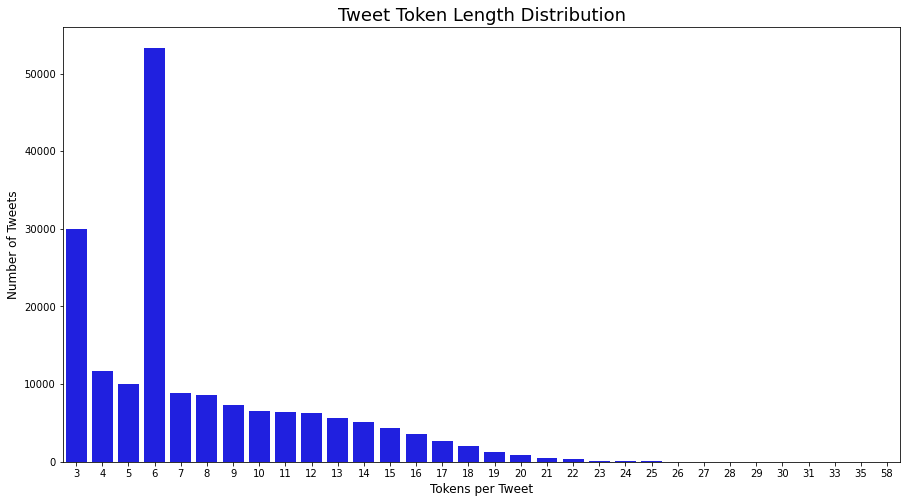

In [153]:
plt.figure(figsize = (15,8))
sns.countplot(tweet_lengths, color='blue')
plt.title('Tweet Token Length Distribution', fontsize = 18)
plt.xlabel('Tokens per Tweet', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize = 12)
plt.show()

In [23]:
flat_words = [item for sublist in tokens_final for item in sublist]
word_freq = nltk.probability.FreqDist(flat_words)
word_freq.most_common(50)

[('stand', 119561),
 ('right', 66076),
 ('respected', 64388),
 ('racial_discrimination', 50068),
 ('condemn_violence', 49575),
 ('racism', 10166),
 ('thank', 9963),
 ('asian', 9228),
 ('people', 5796),
 ('hate', 5431),
 ('violence', 5288),
 ('need', 5117),
 ('love', 4839),
 ('community', 4475),
 ('voice', 4413),
 ('stop', 3962),
 ('time', 3743),
 ('comedy', 3650),
 ('asian_american', 3295),
 ('support', 3242),
 ('speak', 3152),
 ('know', 3122),
 ('world', 3019),
 ('discrimination', 3012),
 ('like', 2826),
 ('solidarity', 2692),
 ('help', 2675),
 ('idea_rasicsm', 2639),
 ('speaking', 2550),
 ('day', 2514),
 ('way', 2441),
 ('country', 2334),
 ('human', 2258),
 ('racist', 2249),
 ('want', 2125),
 ('hate_crimes', 2094),
 ('family', 2057),
 ('sharing', 2055),
 ('life', 2019),
 ('atlanta', 2011),
 ('today', 1994),
 ('matter', 1988),
 ('victim', 1984),
 ('experience', 1959),
 ('attack', 1938),
 ('word', 1909),
 ('platform', 1886),
 ('hope', 1850),
 ('asian_community', 1850),
 ('bts', 1835)]

## Latent Dirichlet Allocation

In [24]:
# Make dictionary and corpus out of tokens
text_dict = gensim.corpora.Dictionary(tokens_final)
text_dict.filter_extremes(no_below=5)
tweets_bow = [text_dict.doc2bow(tweet) for tweet in tokens_final]

In [54]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

### Asymmetric Priors LDA

In [52]:
coherence_values = []
model_list = []

# Loop over potential numbers of topics
for k in range(2, 21):
    
    # Train LDA model
    model = LdaMulticore(corpus=tweets_bow, 
                         id2word=text_dict, 
                         num_topics=k, 
                         eta='auto',
                         alpha='asymmetric',
                         eval_every=20,
                         passes=20,
                         random_state=1)
    model_list.append(model)
    print(f"Fit model with {k} topics")
    
    # Get coherence value
    coherencemodel = CoherenceModel(model=model, 
                                    texts=tokens_final, 
                                    dictionary=text_dict, 
                                    coherence='c_v')
    coherence = coherencemodel.get_coherence()
    coherence_values.append(coherence)
    print(f"Coherence: {coherence}")
    print("")

Fit model with 2 topics
Coherence: 0.3406380044481654

Fit model with 3 topics
Coherence: 0.41115754948401534

Fit model with 4 topics
Coherence: 0.4808045979073181

Fit model with 5 topics
Coherence: 0.47014524111654543

Fit model with 6 topics
Coherence: 0.414040526205594

Fit model with 7 topics
Coherence: 0.4410819455741657

Fit model with 8 topics
Coherence: 0.47006586099909137

Fit model with 9 topics
Coherence: 0.43869324399989623

Fit model with 10 topics
Coherence: 0.4186279304688581

Fit model with 11 topics
Coherence: 0.4448059393264688

Fit model with 12 topics
Coherence: 0.4433984949377816

Fit model with 13 topics
Coherence: 0.4345291373430997

Fit model with 14 topics
Coherence: 0.4539845278050993

Fit model with 15 topics
Coherence: 0.44119087408575614

Fit model with 16 topics
Coherence: 0.4613602513024727

Fit model with 17 topics
Coherence: 0.46452160888412103

Fit model with 18 topics
Coherence: 0.451875795247781

Fit model with 19 topics
Coherence: 0.45795458280686

In [56]:
best_model_idx  = np.argmax(coherence_values)
best_num_topics = best_model_idx+2
best_model = model_list[best_model_idx]
print(f"Best model has {best_num_topics} topics")

Best model has 4 topics


### Symmetric Priors LDA

In [53]:
coherence_values_symm = []
model_list_symm = []

# Loop over potential numbers of topics
for k in range(2, 21):
    
    # Train LDA model
    model = LdaMulticore(corpus=tweets_bow, 
                         id2word=text_dict, 
                         num_topics=k, 
                         eval_every=20,
                         passes=20,
                         random_state=1)
    model_list_symm.append(model)
    print(f"Fit model with {k} topics")
    
    # Get coherence value
    coherencemodel = CoherenceModel(model=model, 
                                    texts=tokens_final, 
                                    dictionary=text_dict, 
                                    coherence='c_v')
    coherence = coherencemodel.get_coherence()
    coherence_values_symm.append(coherence)
    print(f"Coherence: {coherence}")
    print("")

Fit model with 2 topics
Coherence: 0.373350023343944

Fit model with 3 topics
Coherence: 0.39918241044272507

Fit model with 4 topics
Coherence: 0.4822532292223666

Fit model with 5 topics
Coherence: 0.48586945093682565

Fit model with 6 topics
Coherence: 0.46900927378718277

Fit model with 7 topics
Coherence: 0.439037327694093

Fit model with 8 topics
Coherence: 0.4708990901670902

Fit model with 9 topics
Coherence: 0.4898498899647232

Fit model with 10 topics
Coherence: 0.4722690177500251

Fit model with 11 topics
Coherence: 0.5032442705561682

Fit model with 12 topics
Coherence: 0.48442704783164897

Fit model with 13 topics
Coherence: 0.46023479173759885

Fit model with 14 topics
Coherence: 0.46361315889322297

Fit model with 15 topics
Coherence: 0.43631274991595503

Fit model with 16 topics
Coherence: 0.4936238184957421

Fit model with 17 topics
Coherence: 0.45903323414304337

Fit model with 18 topics
Coherence: 0.46173638039093795

Fit model with 19 topics
Coherence: 0.48758902106

In [59]:
best_model_idx  = np.argmax(coherence_values_symm)
best_num_topics = best_model_idx+2
best_model = model_list_symm[best_model_idx]
print(f"Best model has {best_num_topics} topics")

Best model has 11 topics


C:\Users\steve\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### TF-IDF Corpus LDA

In [67]:
# Make tf-idf model instead
tfidf = gensim.models.TfidfModel(tweets_bow)
tweets_tfidf = tfidf[tweets_bow]

C:\Users\steve\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
coherence_values_tfidf = []
model_list_tfidf = []

# Loop over potential numbers of topics
for k in range(2, 21):
    
    # Train LDA model
    model = LdaMulticore(corpus=tweets_tfidf, 
                         id2word=text_dict, 
                         num_topics=k, 
                         eval_every=20,
                         passes=20,
                         random_state=1)
    model_list_tfidf.append(model)
    print(f"Fit model with {k} topics")
    
    # Get coherence value
    coherencemodel = CoherenceModel(model=model, 
                                    texts=tokens_final, 
                                    dictionary=text_dict, 
                                    coherence='c_v')
    coherence = coherencemodel.get_coherence()
    coherence_values_tfidf.append(coherence)
    print(f"Coherence: {coherence}")
    print("")

C:\Users\steve\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fit model with 2 topics
Coherence: 0.43361566845600286

Fit model with 3 topics
Coherence: 0.37766888828124506

Fit model with 4 topics
Coherence: 0.44684885232234905

Fit model with 5 topics
Coherence: 0.4510699331744986

Fit model with 6 topics
Coherence: 0.45484517308734146

Fit model with 7 topics
Coherence: 0.47895525279979306

Fit model with 8 topics
Coherence: 0.47516883069105675

Fit model with 9 topics
Coherence: 0.4587917165208773

Fit model with 10 topics
Coherence: 0.4280686437242457

Fit model with 11 topics
Coherence: 0.47642063978438975

Fit model with 12 topics
Coherence: 0.4692203460820317

Fit model with 13 topics
Coherence: 0.4632806081334509

Fit model with 14 topics
Coherence: 0.45997429311781624

Fit model with 15 topics
Coherence: 0.4968157137855497

Fit model with 16 topics
Coherence: 0.5006748817034403

Fit model with 17 topics
Coherence: 0.4963523071973684

Fit model with 18 topics
Coherence: 0.5184374296061507

Fit model with 19 topics
Coherence: 0.4928766732

In [100]:
best_model_idx  = np.argmax(coherence_values_tfidf)
best_num_topics = best_model_idx+2
best_model = model_list_tfidf[best_model_idx]
print(f"Best model has {best_num_topics} topics")

Best model has 18 topics


C:\Users\steve\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Look at Optimal Topic Numbers

C:\Users\steve\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


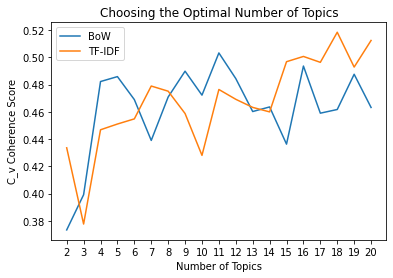

In [99]:
plt.plot(np.arange(2,21), coherence_values_symm)
plt.plot(np.arange(2,21), coherence_values_tfidf)
plt.title("Choosing the Optimal Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("C_v Coherence Score")
plt.legend(['BoW','TF-IDF'])
plt.xticks(np.arange(2,21,1))
plt.show()

### Visualize Topics in Best Model

In [87]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_list_tfidf[18-2], tweets_tfidf, dictionary=best_model.id2word)
vis

C:\Users\steve\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.111346 -0.503218       1        1  21.760785
14    -0.244283  0.011673       2        1   9.047486
2     -0.234552  0.021204       3        1   8.318035
1     -0.225329  0.001664       4        1   8.169606
6     -0.175027  0.028026       5        1   6.168022
17    -0.141799 -0.102265       6        1   6.101076
13    -0.172752  0.052755       7        1   5.770073
16    -0.076714 -0.043669       8        1   4.475904
0     -0.074053  0.062007       9        1   3.929901
10    -0.049510  0.042867      10        1   3.899995
15     0.184641 -0.014327      11        1   3.789973
5      0.099137  0.067216      12        1   3.185486
4      0.152916  0.046688      13        1   2.735717
3      0.153569  0.066333      14        1   2.696225
11     0.136697  0.050504      15        1   2.630645
7      0.206283  0.052819      16        1   2.566153
12     0.154152  0.078311      17        1   2.555417
9      0.195277  0.081410      18        1   2.199500, topic_info=                       Term          Freq         Total Category  logprob  \
684                   stand  26557.000000  26557.000000  Default  30.0000   
4549       condemn_violence  15874.000000  15874.000000  Default  29.0000   
871   racial_discrimination  15799.000000  15799.000000  Default  28.0000   
4550              respected  16962.000000  16962.000000  Default  27.0000   
182                   right  16620.000000  16620.000000  Default  26.0000   
...                     ...           ...           ...      ...      ...   
2481    anti_asian_violence     33.000357     34.384418  Topic18  -5.6380   
34                      men    150.693525    244.285037  Topic18  -4.1192   
7565            skin_colour     40.131534     44.846987  Topic18  -5.4423   
7946                 carrds     55.310970     82.854450  Topic18  -5.1215   
1440     antiasian_violence     73.214363    249.523473  Topic18  -4.8411   

      loglift  
684   30.0000  
4549  29.0000  
871   28.0000  
4550  27.0000  
182   26.0000  
...       ...  
2481   3.7759  
34     3.3339  
7565   3.7058  
7946   3.4128  
1440   2.5908  

[1000 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
3276      3  0.108501                  ()
3276      4  0.054251                  ()
3276     10  0.732382                  ()
3276     12  0.094938                  ()
833       4  0.978788  (aapi)_populations
...     ...       ...                 ...
5119      8  0.331948               youre
5667      9  0.969191               youth
3513      3  0.027975             youtube
3513     14  0.951159             youtube
7486     14  0.986120               yumma

[2446 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 15, 3, 2, 7, 18, 14, 17, 1, 11, 16, 6, 5, 4, 12, 8, 13, 10])

### Try HDP

In [116]:
from gensim.models import HdpModel
hdp = HdpModel(corpus=tweets_bow, 
               id2word=text_dict)

C:\Users\steve\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Dirichlet Mixture Model (DMM)

In [123]:
from gsdmm import MovieGroupProcess

mgp     = MovieGroupProcess(K=18, n_iters=30)
vocab   = set(x for tweet in tokens_final for x in tweet)
n_terms = len(vocab)
model   = mgp.fit(tokens_final, n_terms)

C:\Users\steve\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In stage 0: transferred 159054 clusters with 18 clusters populated
In stage 1: transferred 112338 clusters with 18 clusters populated
In stage 2: transferred 45028 clusters with 18 clusters populated
In stage 3: transferred 29620 clusters with 18 clusters populated
In stage 4: transferred 23543 clusters with 18 clusters populated
In stage 5: transferred 20059 clusters with 18 clusters populated
In stage 6: transferred 18129 clusters with 18 clusters populated
In stage 7: transferred 17035 clusters with 18 clusters populated
In stage 8: transferred 16368 clusters with 18 clusters populated
In stage 9: transferred 15861 clusters with 18 clusters populated
In stage 10: transferred 15555 clusters with 18 clusters populated
In stage 11: transferred 15665 clusters with 18 clusters populated
In stage 12: transferred 15442 clusters with 18 clusters populated
In stage 13: transferred 15365 clusters with 18 clusters populated
In stage 14: transferred 14941 clusters with 18 clusters populated
In 

### Identify Top Words in GS-DMM Model

In [147]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster, sort_dicts))

doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-18:]
print('\nMost important clusters (by number of docs inside):', top_index)

top_words(mgp.cluster_word_distribution, top_index, 10)

Number of documents per topic : [13283  7449   921   543 17337   968 62874 17763 13768  2841 10093   401
   736  4802   626   615 19417  1299]

Most important clusters (by number of docs inside): [11  3 15 14 12  2  5 17  9 13  1 10  0  8  4  7 16  6]

Cluster 11 : [('\xa0', 175), ('info', 100), ('playing', 97), ('place', 96), ('twitch', 96), ('est', 95), ('announced_scry', 94), ("society's", 94), ('official_stream', 94), ('saturday_april', 94)]

Cluster 3 : [('asian_american', 401), ('time', 387), ('killed', 383), ('literally', 378), ('asian_men', 378), ('optic', 377), ('literally_beaten', 377), ('product_showing', 376), ('appallingly_racist', 376), ('poor_taste', 375)]

Cluster 15 : [('fact', 222), ('alive', 123), ("we're_alive", 94), ('respected_right', 93), ('respected', 72), ('respected_kim_namjoon', 49), ('virus', 39), ('asian', 33), ('virus_truth', 33), ('covering', 31)]

Cluster 14 : [('video', 46), ('investigation', 34), ('check', 30), ('atlanta_shootings', 25), ('coming', 23)

C:\Users\steve\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Classify Tweets By Topic

In [131]:
topic_dict = {}
topic_names = [f"Topic {k}" for k in range(18)]
for i,topic_num in enumerate(top_index):
    topic_dict[topic_num] = topic_names[i] 

result = pd.DataFrame(columns=['Text', 'Topic', 'Lemmatized'])
for i,text in enumerate(main_df['content_clean']):
    result.loc[i,'Text'] = text
    result.loc[i,'Lemmatized'] = tokens_lemmatized[i]
    prob = mgp.choose_best_label(tokens_lemmatized[i])
    if prob[1] >= 0.25:
        result.loc[i,'Topic'] = topic_dict[prob[0]]
    else:
        result.loc[i,'Topic'] = 'Unknown'

C:\Users\steve\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Randomly Choose Tweets from Topics

In [133]:
for topic_name in topic_names:
    curr_topic_tweets = result[result['Topic'] == topic_name]
    sampling = curr_topic_tweets.sample(n=10)
    print(topic_name)
    for tweet_text in sampling['Text']:
        print("\t"+tweet_text)

C:\Users\steve\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 0
	shut up your mouth don't make fake news about covid
	may at pm pst/pm est ph time may am rsvp at
	people out here forming a barricade around policetrying to protecttgem against an angry crowd in atlanta
	sorry but the guy running away clearly aimed back at the cop what's a cop supposed to do in a case like that the police chief is an idiot but the copt is not at fault here atlanta  via
	our own asian immigrant members are facing a threefold crisis antiasian violence covid exposure and risk of deportation we must immediately and provide immigrants a path to citizenship call congress to make this happen
	rihanna goes undercover at 'stop asian hate' rally in nyc via rhihanna ihs shtill the tho
	asian hate shut up your mouth don't make fake news about covid
	i just announced scry society's first official stream which will take place on saturday april th pm est we are playing a oneshot and raising money for we're hoping to hit followers on twitch before then more info below
	intere

In [149]:
result.to_csv('data/dgmm_results.csv')
result.head()

C:\Users\steve\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Text,Topic,Lemmatized
0,we've raised thru tix sticker pack sales so f...,Topic 11,"[we've_raised, tix, sticker_pack, sale, far, p..."
1,thank you and all of the family for your ongoi...,Topic 15,"[thank, family, ongoing, support, teamwork, co..."
2,do we have a picture of the racist perp maybe ...,Topic 13,"[picture, racist, perp, maybe, community, help..."
3,southern fried asian panel on,Topic 15,"[southern, fried, asian, panel]"
4,bitch how do you mispronounce boba,Topic 13,"[bitch, mispronounce, boba]"


### Make wordclouds

C:\Users\steve\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


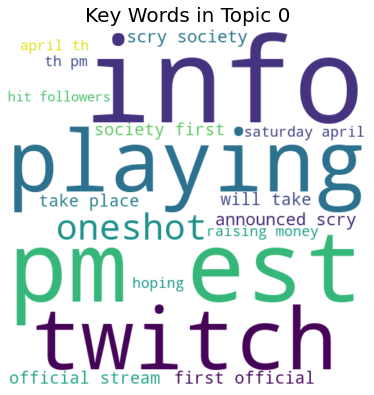

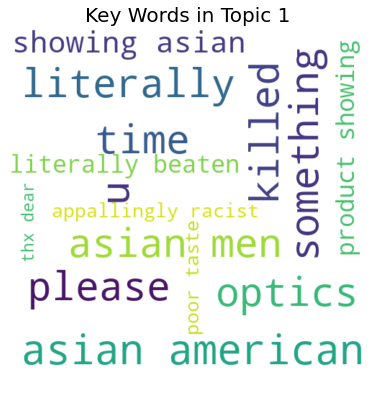

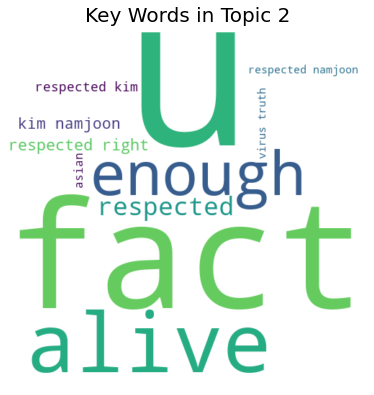

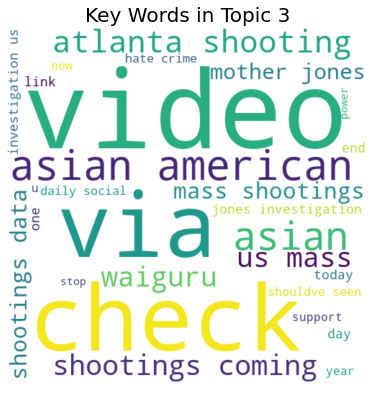

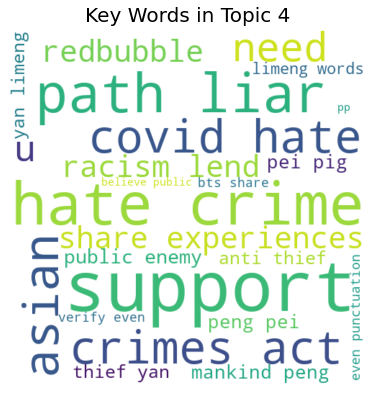

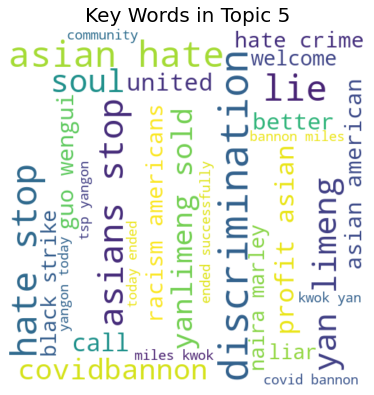

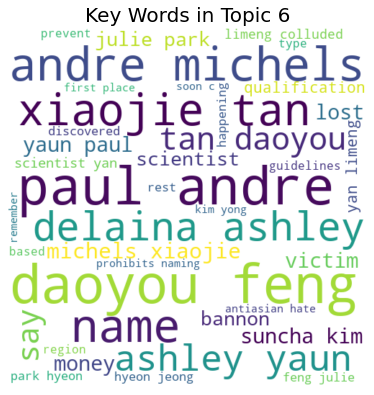

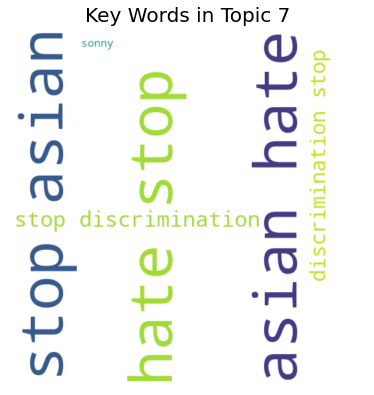

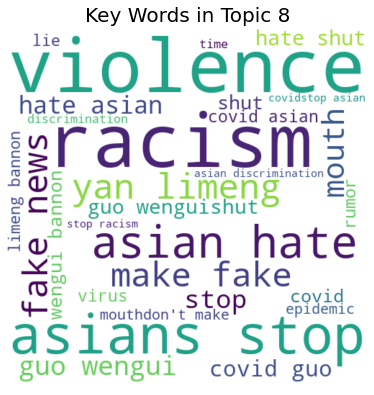

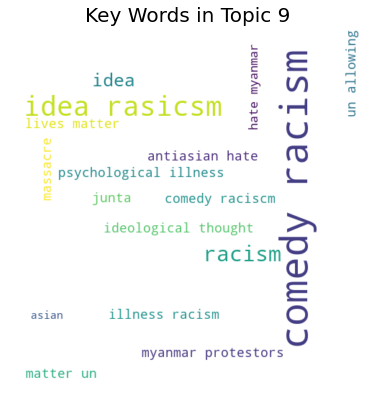

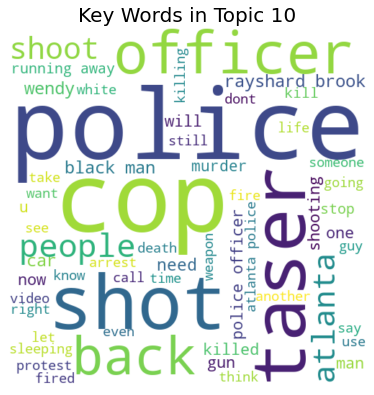

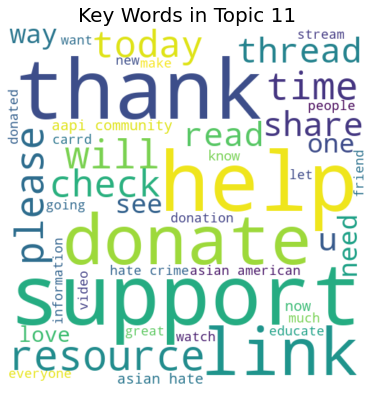

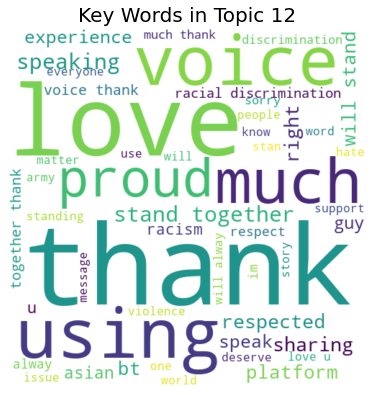

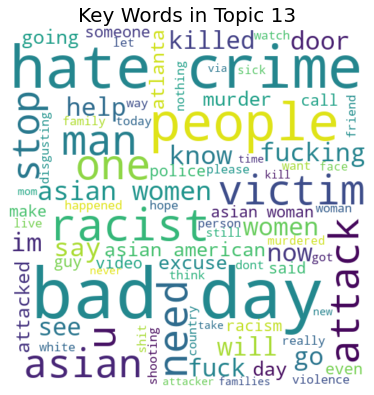

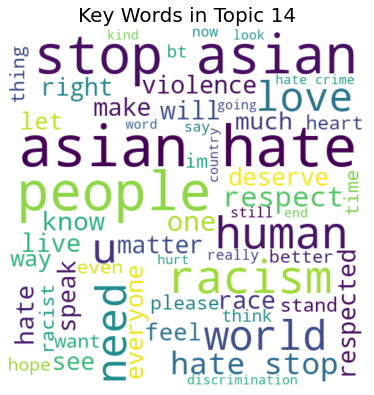

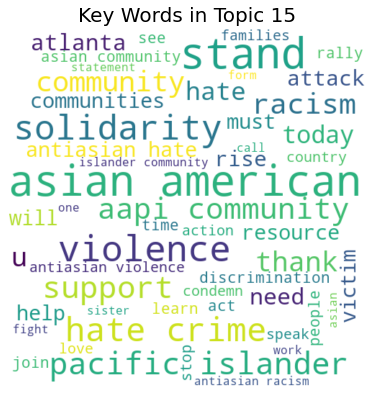

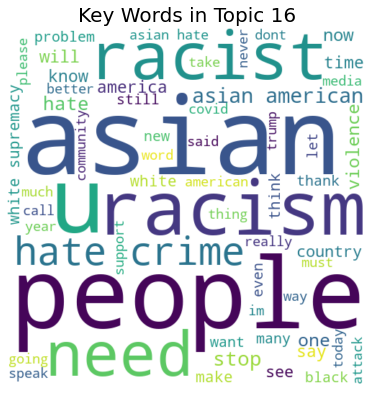

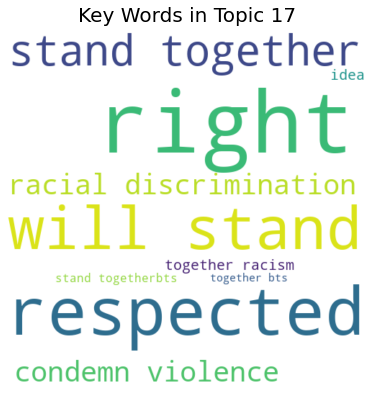

In [151]:
from wordcloud import WordCloud 
def make_wordcloud(df, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(df.values))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show() 

for i in range(18):
    make_wordcloud(result['Text'].loc[result.Topic == f'Topic {i}'], f"Key Words in Topic {i}")